In [1]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import vapeplot
from matplotlib.lines import Line2D

# SITA
## Auxiliary Function

In [2]:
def _b(alpha, E_L):
    return E_L * (alpha - 1) / alpha

## $\mathbb{P}(L<\theta)$ and $\mathbb{P}(L>\theta)$

In [3]:
def P_L_less_theta(theta, b, alpha):
    return (1 - (b/theta) ** alpha)

def P_L_greater_theta(theta, b, alpha):
    return (b/theta) ** alpha

## Arrival Rates  $\Lambda$, $\lambda_1$, $\lambda_2$

In [4]:
def LAMBDA(rho, mu_1, mu_2, E_L):
    return rho * (mu_1+mu_2) / E_L

def lambda_1(l, theta, b, alpha):
    return l * P_L_less_theta(theta, b, alpha)

def lambda_2(l, theta, b, alpha):
    return l * P_L_greater_theta(theta, b, alpha)

## Service Times for $X_1$ and $X_2$

In [5]:
def mean_X_1(theta, b, alpha, mu_1):
    fact_1 = 1 / mu_1
    fact_2 = b**alpha / (1 - (b / theta)**alpha)
    fact_3 = alpha / (alpha - 1)
    fact_4 = 1 / b ** (alpha-1) - 1 / theta ** (alpha - 1)
    return fact_1 * fact_2 * fact_3 * fact_4

def second_moment_X_1(theta, b, alpha, mu_1):
    fact_1 = 1 / mu_1 ** 2
    fact_2 = b**alpha / (1 - (b / theta)**alpha)
    fact_3 = alpha / (alpha - 2)
    fact_4 = 1 / b ** (alpha-2) - 1 / theta ** (alpha-2)
    return fact_1 * fact_2 * fact_3 * fact_4

def mean_X_2(theta, alpha, mu_2):
    return theta * (alpha / (alpha - 1)) / mu_2

def second_moment_X_2(theta, alpha, mu_2):
    return (theta ** 2) * (alpha / (alpha - 2)) / (mu_2 ** 2)

## Mean Service Time $\mathbb{E}[S_1], \mathbb{E}[S_2]$

In [6]:
def mean_S_1(rho, theta, b, alpha, mu_1, mu_2, E_L=1):
    l_1 = lambda_1(LAMBDA(rho, mu_1, mu_2, E_L), theta, b, alpha)
    E_X_1 = mean_X_1(theta, b, alpha, mu_1)
    num = l_1 * second_moment_X_1(theta, b, alpha, mu_1)
    den = 2 * (1 - l_1 * E_X_1)
    return E_X_1 + num / den

def mean_S_2(rho, theta, b, alpha, mu_1, mu_2, E_L=1):
    l_2 = lambda_2(LAMBDA(rho, mu_1, mu_2, E_L), theta, b, alpha)
    E_X_2 = mean_X_2(theta, alpha, mu_2)
    num = l_2 * second_moment_X_2(theta, alpha, mu_2)
    den = 2 * (1 - l_2 * E_X_2)
    return E_X_2 + num / den

## Mean Delay $\mathbb{E}[D]$

In [7]:
def mean_D(theta, rho, alpha, mu_1, mu_2, E_L=1):
    b = _b(alpha, E_L=E_L)
    d_1 = P_L_less_theta(theta, b, alpha) * mean_S_1(rho, theta, b, alpha, mu_1, mu_2, E_L=E_L)
    d_2 = P_L_greater_theta(theta, b, alpha) * mean_S_2(rho, theta, b, alpha, mu_1, mu_2, E_L=E_L)
    return d_1 + d_2

## Find $\theta^*$ = min $\mathbb{E}[D]$

In [8]:
def theta_min(rho, mu_1, mu_2, alpha, E_L=1):
    stability_cond = LAMBDA(rho, mu_1, mu_2, E_L) * (_b(alpha, E_L) ** alpha) * alpha / ((alpha - 1) * mu_2)
    stability_cond = stability_cond ** (1 / (alpha - 1))
    return max(stability_cond, _b(alpha, E_L))

def theta_max(rho, mu_1, mu_2, alpha, E_L=1):
    b = _b(alpha, E_L=E_L)
    L = LAMBDA(rho, mu_1, mu_2, E_L)
    return 1 / ((b**(1-alpha) - mu_1 / (L * (b**alpha) * (alpha / (alpha -1)))) ** (1 / (alpha - 1)))

def find_theta_opt(rho, mu_1, mu_2, alpha, n_points = 10000):
    eps = 1e-6
    _theta_min = theta_min(rho, mu_1, mu_2, alpha)
    _theta_max = theta_max(rho, mu_1, mu_2, alpha)
    thetas = np.arange(_theta_min + eps, _theta_max, (_theta_max - _theta_min) / n_points)
    mean_Ds = mean_D(thetas, rho, alpha, mu_1, mu_2)
    return thetas[np.argmin(mean_Ds)]

# Results

In [9]:
mu_1 = 1
mu_2 = 10
alpha = 2.25
rho = 0.5
rhos = np.arange(0.5, 0.9, 1/1000)
alphas = [2.01, 2.05, 2.25]
SITA_df = pd.concat([pd.DataFrame({'theta_opt': [find_theta_opt(rho, mu_1, mu_2, alpha) for rho in rhos],
                                   'rho': rhos, 
                                   'alpha': alpha,
                                   'mean_delay': [mean_D(find_theta_opt(rho, mu_1, mu_2, alpha), rho, alpha, mu_1, mu_2) for rho in rhos]})
                     for alpha in alphas])
SITA_df['method'] = 'SITA'

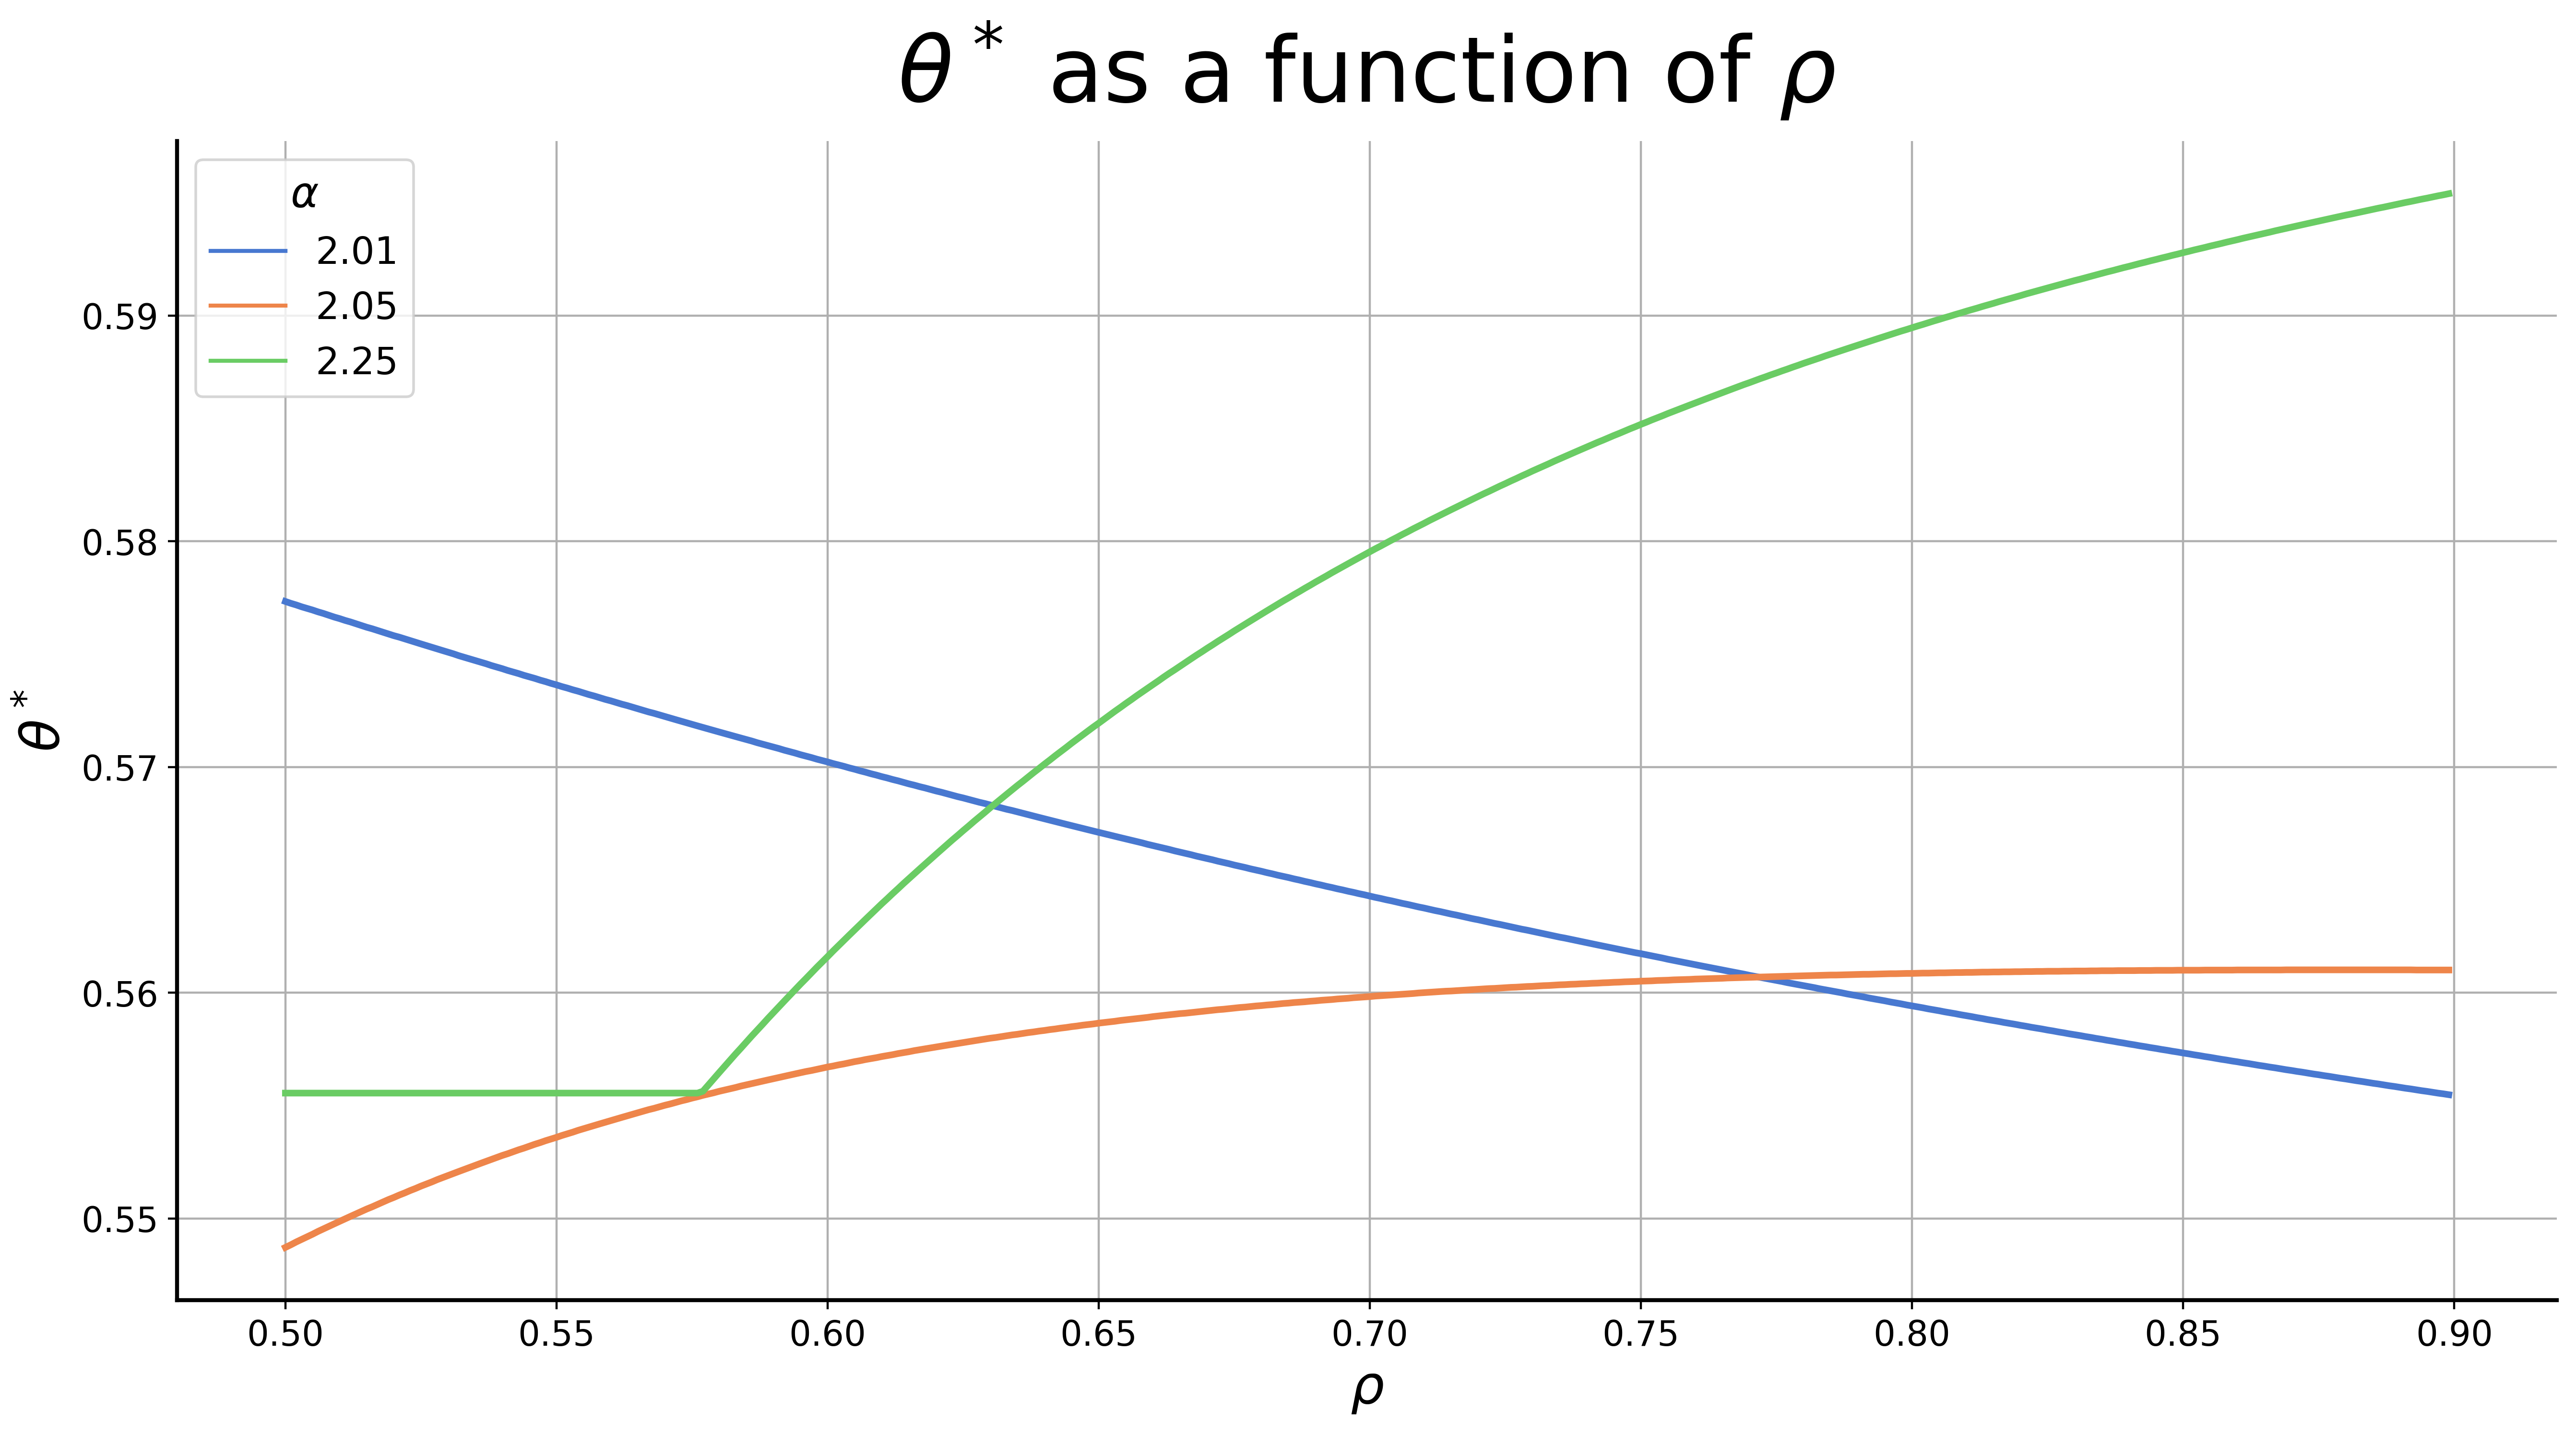

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16,8), dpi=400)
plt.title(r'$\theta^*$ as a function of $\rho$', fontsize=34, y=1.02)
ax.tick_params(labelsize=13)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
plt.grid(True)
plt.ylabel(r'$\theta^*$', fontsize=20)
plt.xlabel(r'$\rho$', fontsize=20)
sns.lineplot(data=SITA_df, x='rho', y='theta_opt', hue='alpha', palette='muted', linewidth = 2.5)
ax.legend(title=r'$\alpha$', fontsize=14, title_fontsize=16);

# Random
## Arrival Rates $\lambda_1$, $\lambda_2$

In [11]:
def lambda_1_rand(l, p):
    return l * p

def lambda_2_rand(l, p):
    return l * (1 - p)

## Service Times for $X_1$ and $X_2$

In [12]:
def mean_X_1_rand(b, alpha, mu_1):
    return b * (alpha / (alpha-1)) / mu_1

def second_moment_X_1_rand(b, alpha, mu_1):
    return (b ** 2) * (alpha / (alpha - 2)) / (mu_1 ** 2)

def mean_X_2_rand(b, alpha, mu_2):
    return b * (alpha / (alpha-1)) / mu_2

def second_moment_X_2_rand(b, alpha, mu_2):
    return (b ** 2) * (alpha / (alpha - 2)) / (mu_2 ** 2)

## Mean Service Time $\mathbb{E}[S_1], \mathbb{E}[S_2]$

In [13]:
def mean_S_1_rand(rho, p, b, alpha, mu_1, mu_2, E_L=1):
    l_1 = lambda_1_rand(LAMBDA(rho, mu_1, mu_2, E_L), p)
    E_X_1 = mean_X_1_rand(b, alpha, mu_1)
    num = l_1 * second_moment_X_1_rand(b, alpha, mu_1)
    den = 2 * (1 - l_1 * E_X_1)
    return E_X_1 + num / den

def mean_S_2_rand(rho, p, b, alpha, mu_1, mu_2, E_L=1):
    l_2 = lambda_2_rand(LAMBDA(rho, mu_1, mu_2, E_L), p)
    E_X_2 = mean_X_2_rand(b, alpha, mu_2)
    num = l_2 * second_moment_X_2_rand(b, alpha, mu_2)
    den = 2 * (1 - l_2 * E_X_2)
    return E_X_2 + num / den

## Mean Delay $\mathbb{E}[D]$

In [14]:
def mean_D_rand(p, rho, alpha, mu_1, mu_2, E_L=1):
    b = _b(alpha, E_L=E_L)
    d_1 = p * mean_S_1_rand(rho, p, b, alpha, mu_1, mu_2, E_L=E_L)
    d_2 = (1-p) * mean_S_2_rand(rho, p, b, alpha, mu_1, mu_2, E_L=E_L)
    return d_1 + d_2

## Find $p^*$ = min $\mathbb{E}[D]$

In [15]:
def find_p_opt(rho, mu_1, mu_2, alpha, n_points = 10000, E_L=1):
    eps = 1e-6
    b = _b(alpha, E_L=E_L)
    _p_min = max(0, 1 - 1 / (LAMBDA(rho, mu_1, mu_2, E_L) * mean_X_2_rand(b, alpha, mu_2)))
    _p_max = min(1, 1 / (LAMBDA(rho, mu_1, mu_2, E_L) * mean_X_1_rand(b, alpha, mu_1)))
    ps = np.arange(_p_min + eps, _p_max, (_p_max - _p_min) / n_points)
    mean_Ds = mean_D_rand(ps, rho, alpha, mu_1, mu_2)
    return ps[np.argmin(mean_Ds)]

# Results

In [16]:
mu_1 = 1
mu_2 = 10
alpha = 2.25
rho = 0.5
rhos = np.arange(0.5, 0.9, 1/1000)
alphas = [2.01, 2.05, 2.25]
rand_df = pd.concat([pd.DataFrame({'p_opt': [find_p_opt(rho, mu_1, mu_2, alpha) for rho in rhos],
                                   'rho': rhos, 
                                   'alpha': alpha,
                                   'mean_delay': [mean_D_rand(find_p_opt(rho, mu_1, mu_2, alpha), rho, alpha, mu_1, mu_2) for rho in rhos]})
                     for alpha in alphas])
rand_df['method'] = 'rand'

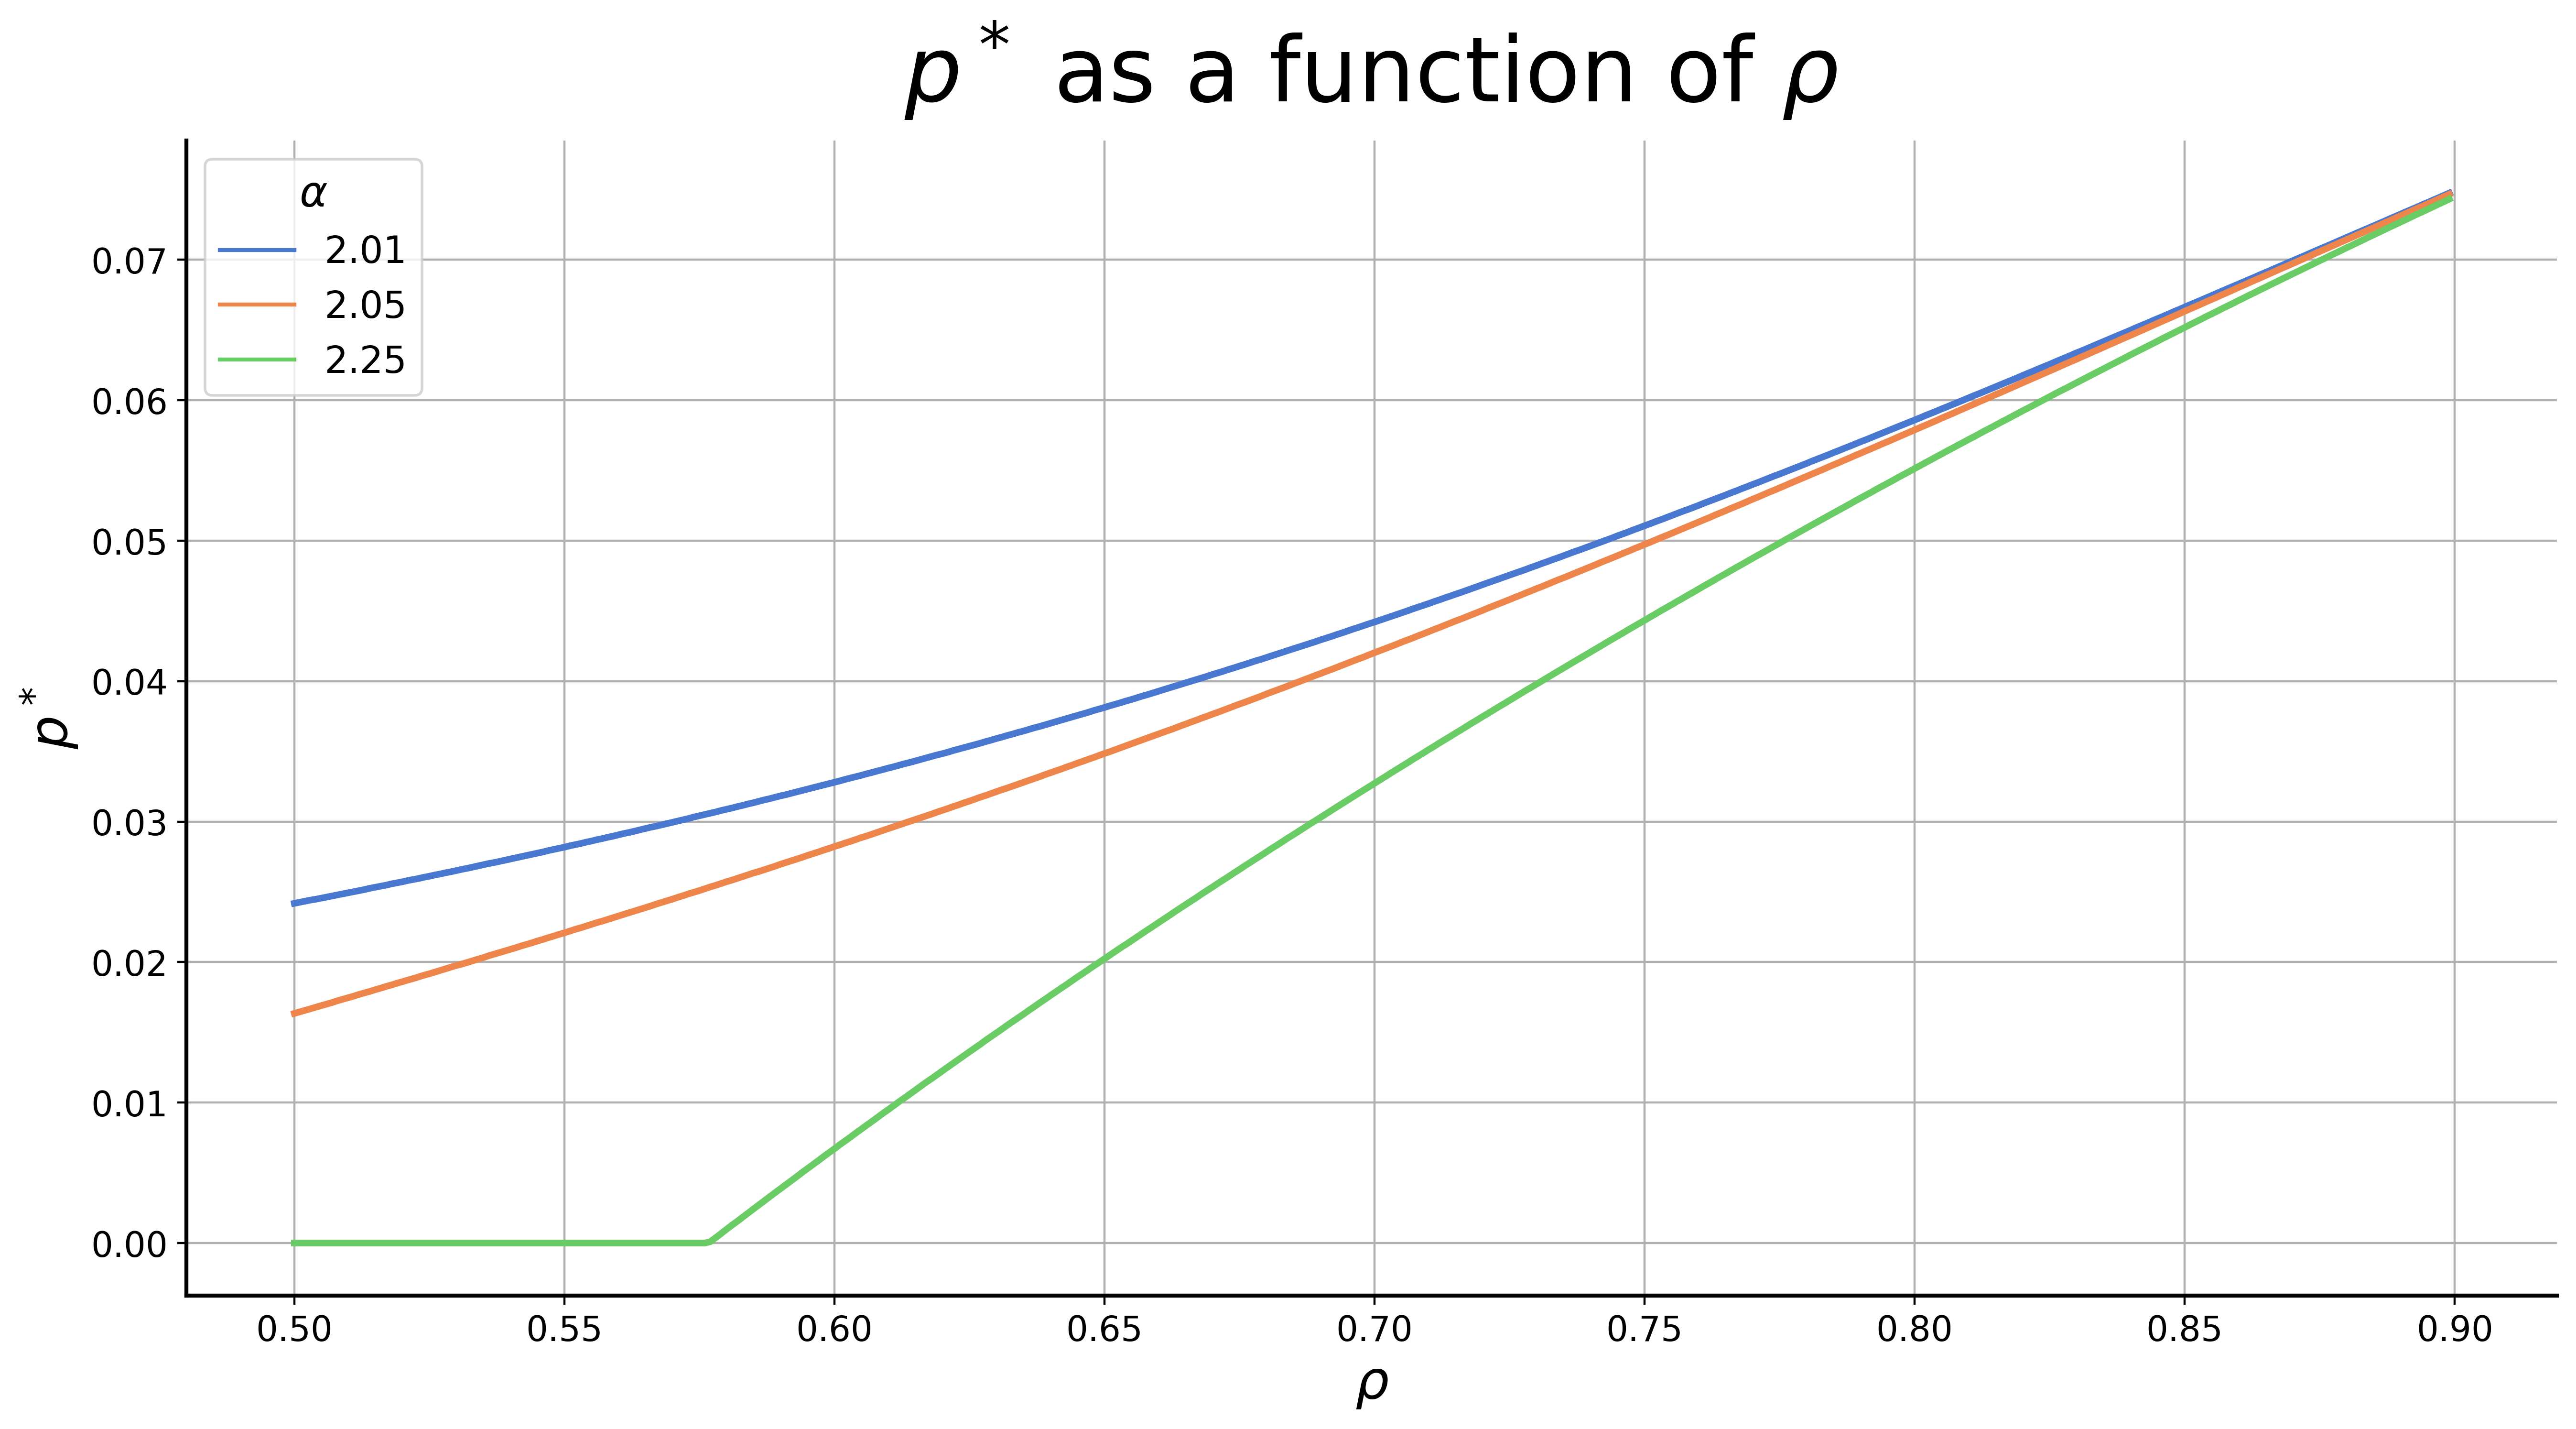

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16,8), dpi=400)
plt.title(r'$p^*$ as a function of $\rho$', fontsize=34, y=1.02)
ax.tick_params(labelsize=13)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
plt.rc('legend', fontsize=14, title_fontsize=16)
plt.grid(True)
plt.ylabel(r'$p^*$', fontsize=20)
plt.xlabel(r'$\rho$', fontsize=20)
sns.lineplot(data=rand_df, x='rho', y='p_opt', hue='alpha', palette='muted', linewidth = 2.5)
ax.legend(title=r'$\alpha$', fontsize=14, title_fontsize=16);

In [18]:
df = pd.concat([rand_df.rename(columns={'p_opt': 'param'}), SITA_df.rename(columns={'theta_opt': 'param'})])

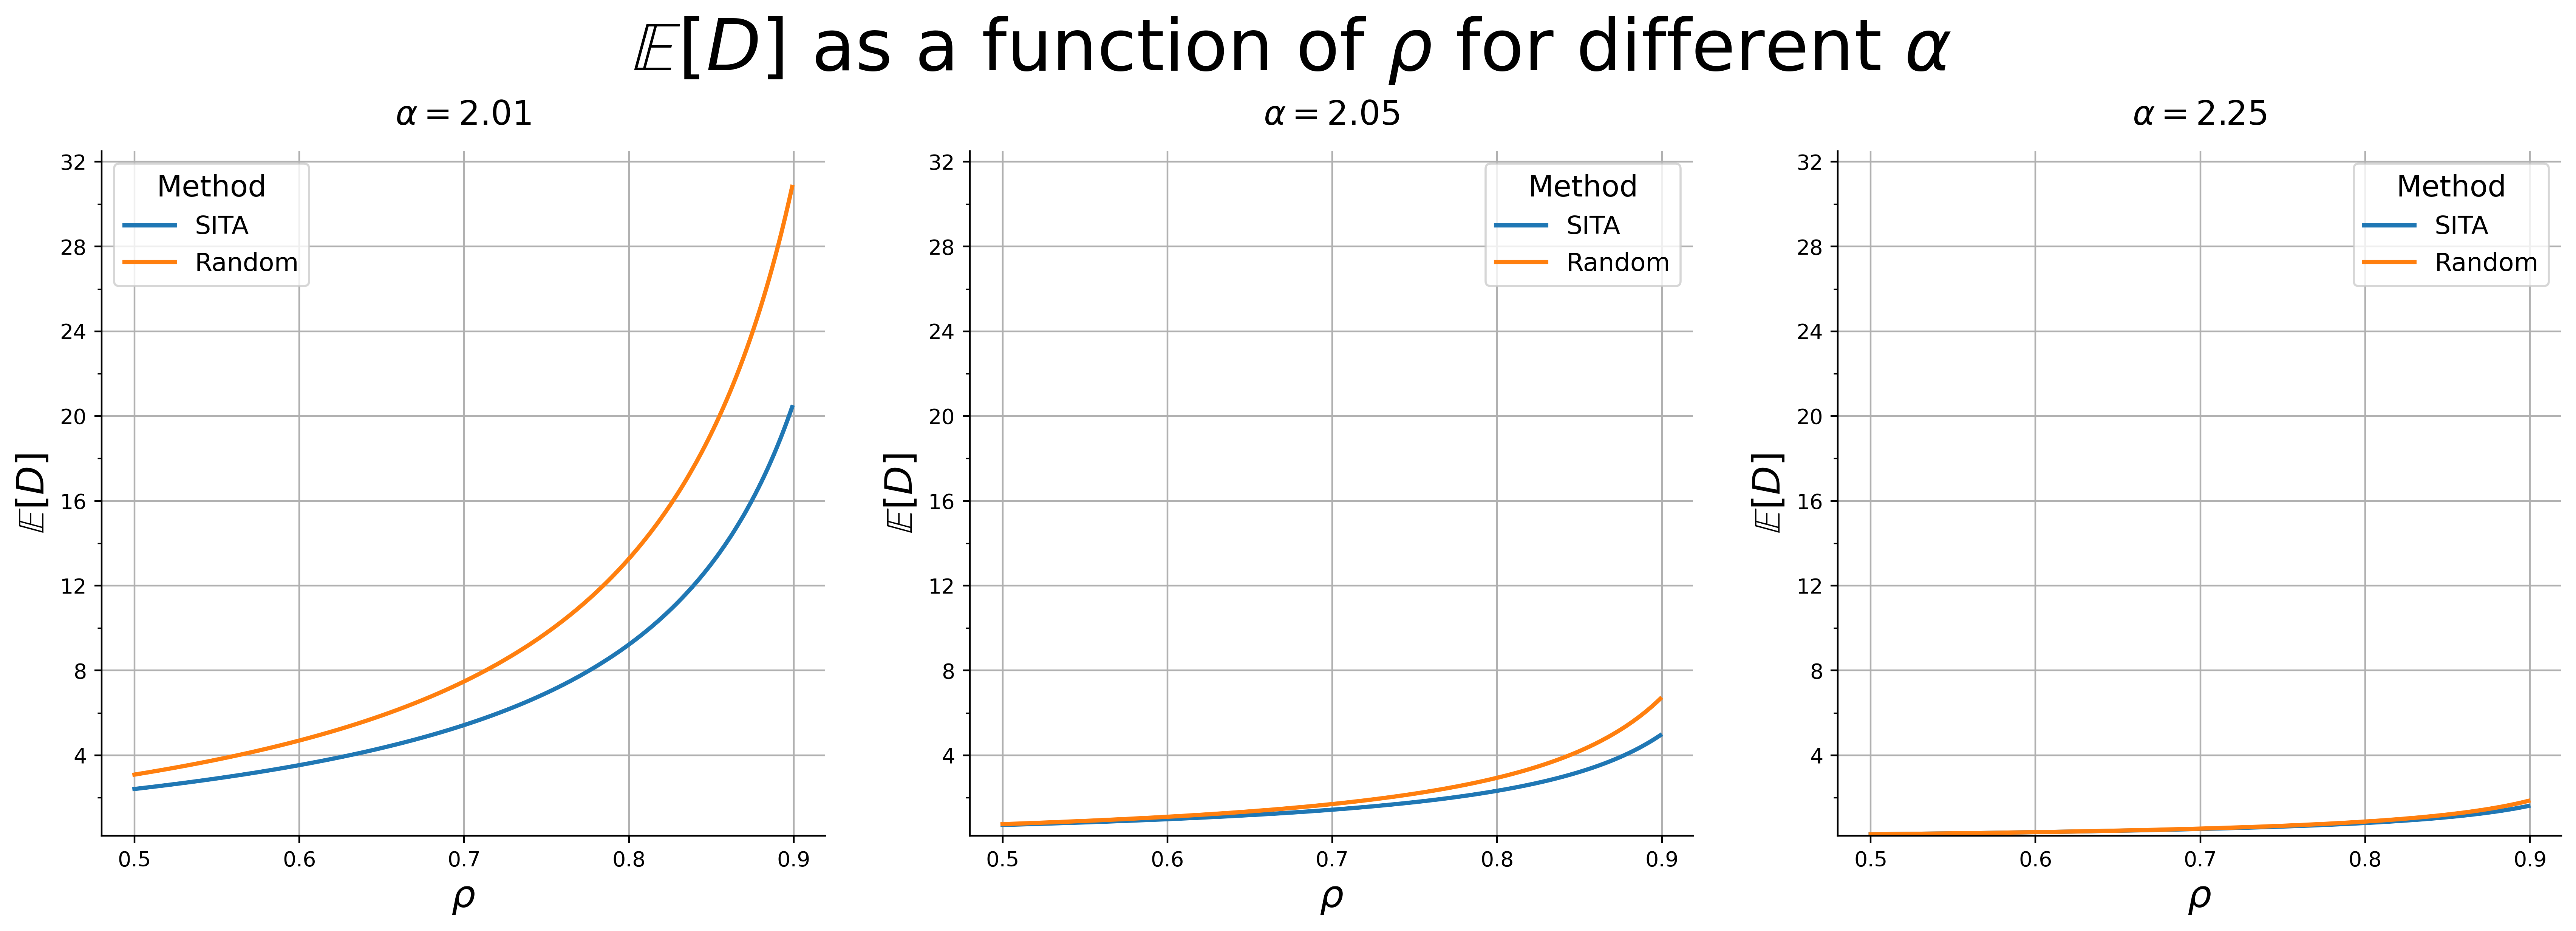

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(21,6), dpi=400)

custom_lines = [Line2D([0], [0], lw=2),
                Line2D([0], [0], color='tab:orange', lw=2)]

fig.suptitle(r'$\mathbb{E}[D]$ as a function of $\rho$ for different $\alpha$', fontsize=34, y=1.03)
for i in range(len(alphas)):
    vapeplot.despine(axs[i])
    axs[i].grid(True)
    axs[i].plot(df[(df.alpha == alphas[i]) & (df.method == 'SITA')].rho, 
                df[(df.alpha == alphas[i]) & (df.method == 'SITA')].mean_delay,
                linewidth=2)
    axs[i].plot(df[(df.alpha == alphas[i]) & (df.method == 'rand')].rho, 
                df[(df.alpha == alphas[i]) & (df.method == 'rand')].mean_delay, 
                'tab:orange',
                linewidth=2)
    axs[i].set_title(r'$\alpha = $' + str(alphas[i]), fontsize=16, y=1.02)
    axs[i].set_ylabel(r'$\mathbb{E}[D]$', fontsize=18)
    axs[i].set_xlabel(r'$\rho$', fontsize=18)
    axs[i].legend(custom_lines, ['SITA', 'Random'], title='Method', fontsize=12, title_fontsize=14)
    axs[i].set_xticks(np.arange(0.5, 0.91, 0.1))
    axs[i].set_yticks(np.arange(0, 32.1, 4) + 2, minor=True)
    axs[i].set_yticks(np.arange(0, 32.1, 4))
    axs[i].set_ylim(0.2, 32.5)

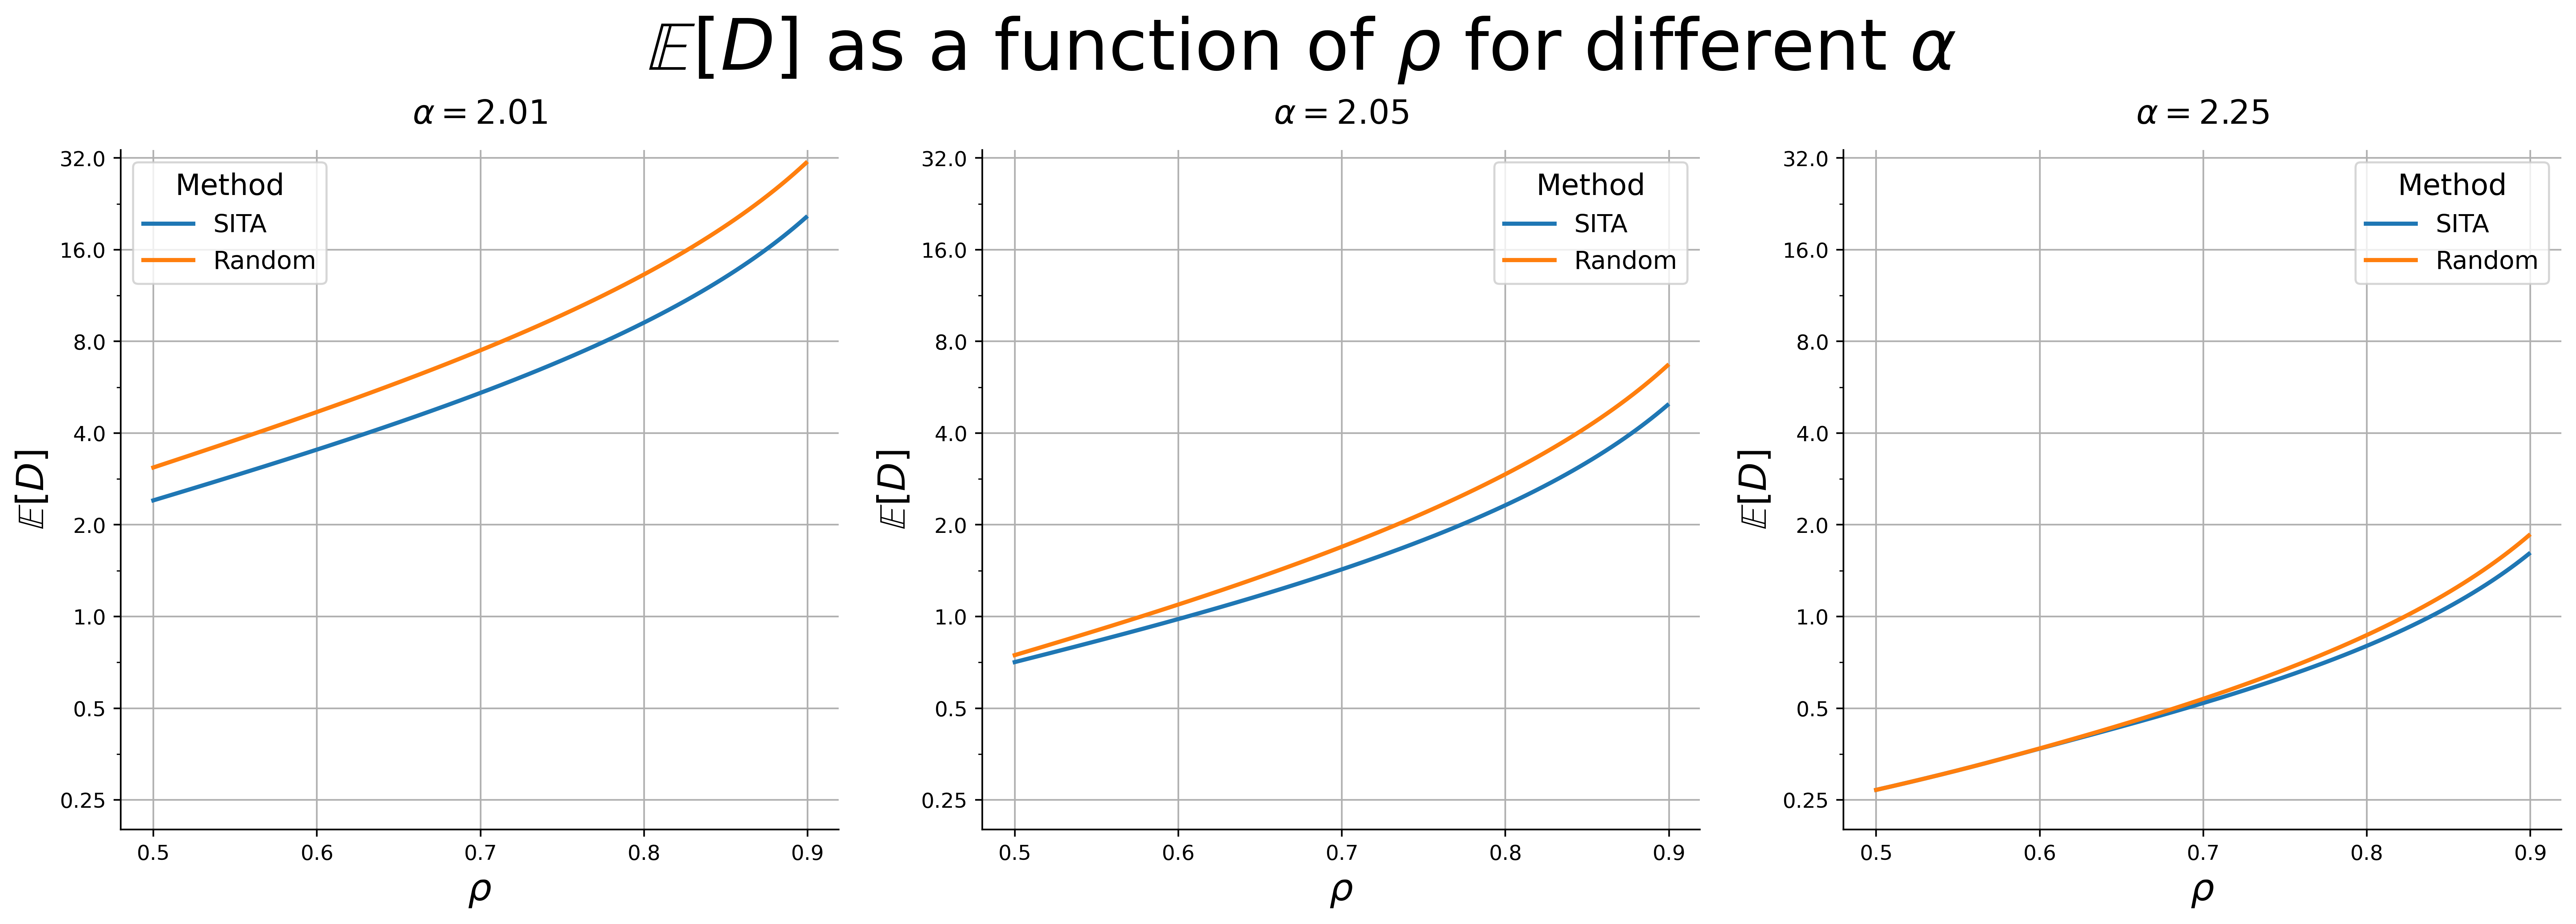

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(21,6), dpi=400)

custom_lines = [Line2D([0], [0], lw=2),
                Line2D([0], [0], color='tab:orange', lw=2)]

fig.suptitle(r'$\mathbb{E}[D]$ as a function of $\rho$ for different $\alpha$', fontsize=34, y=1.03)
for i in range(len(alphas)):
    vapeplot.despine(axs[i])
    axs[i].grid(True)
    axs[i].plot(df[(df.alpha == alphas[i]) & (df.method == 'SITA')].rho, 
                df[(df.alpha == alphas[i]) & (df.method == 'SITA')].mean_delay,
                linewidth=2)
    axs[i].plot(df[(df.alpha == alphas[i]) & (df.method == 'rand')].rho, 
                df[(df.alpha == alphas[i]) & (df.method == 'rand')].mean_delay, 
                'tab:orange',
                linewidth=2)
    axs[i].set_title(r'$\alpha = $' + str(alphas[i]), fontsize=16, y=1.02)
    axs[i].set_ylabel(r'$\mathbb{E}[D]$', fontsize=18)
    axs[i].set_xlabel(r'$\rho$', fontsize=18)
    axs[i].legend(custom_lines, ['SITA', 'Random'], title='Method', fontsize=12, title_fontsize=14)
    axs[i].set_yscale('log')
    axs[i].set_xticks(np.arange(0.5, 0.91, 0.1))
    axs[i].set_yticks(2.**np.arange(-5, 5.01, 1))
    axs[i].set_yticks(2.**(np.arange(-5, 5.01, 1) + 0.5), minor=True)
    axs[i].set_yticklabels(2.**np.arange(-5, 5.01, 1))
    axs[i].set_yticklabels([], minor=True)
    axs[i].set_ylim(0.2, 34)

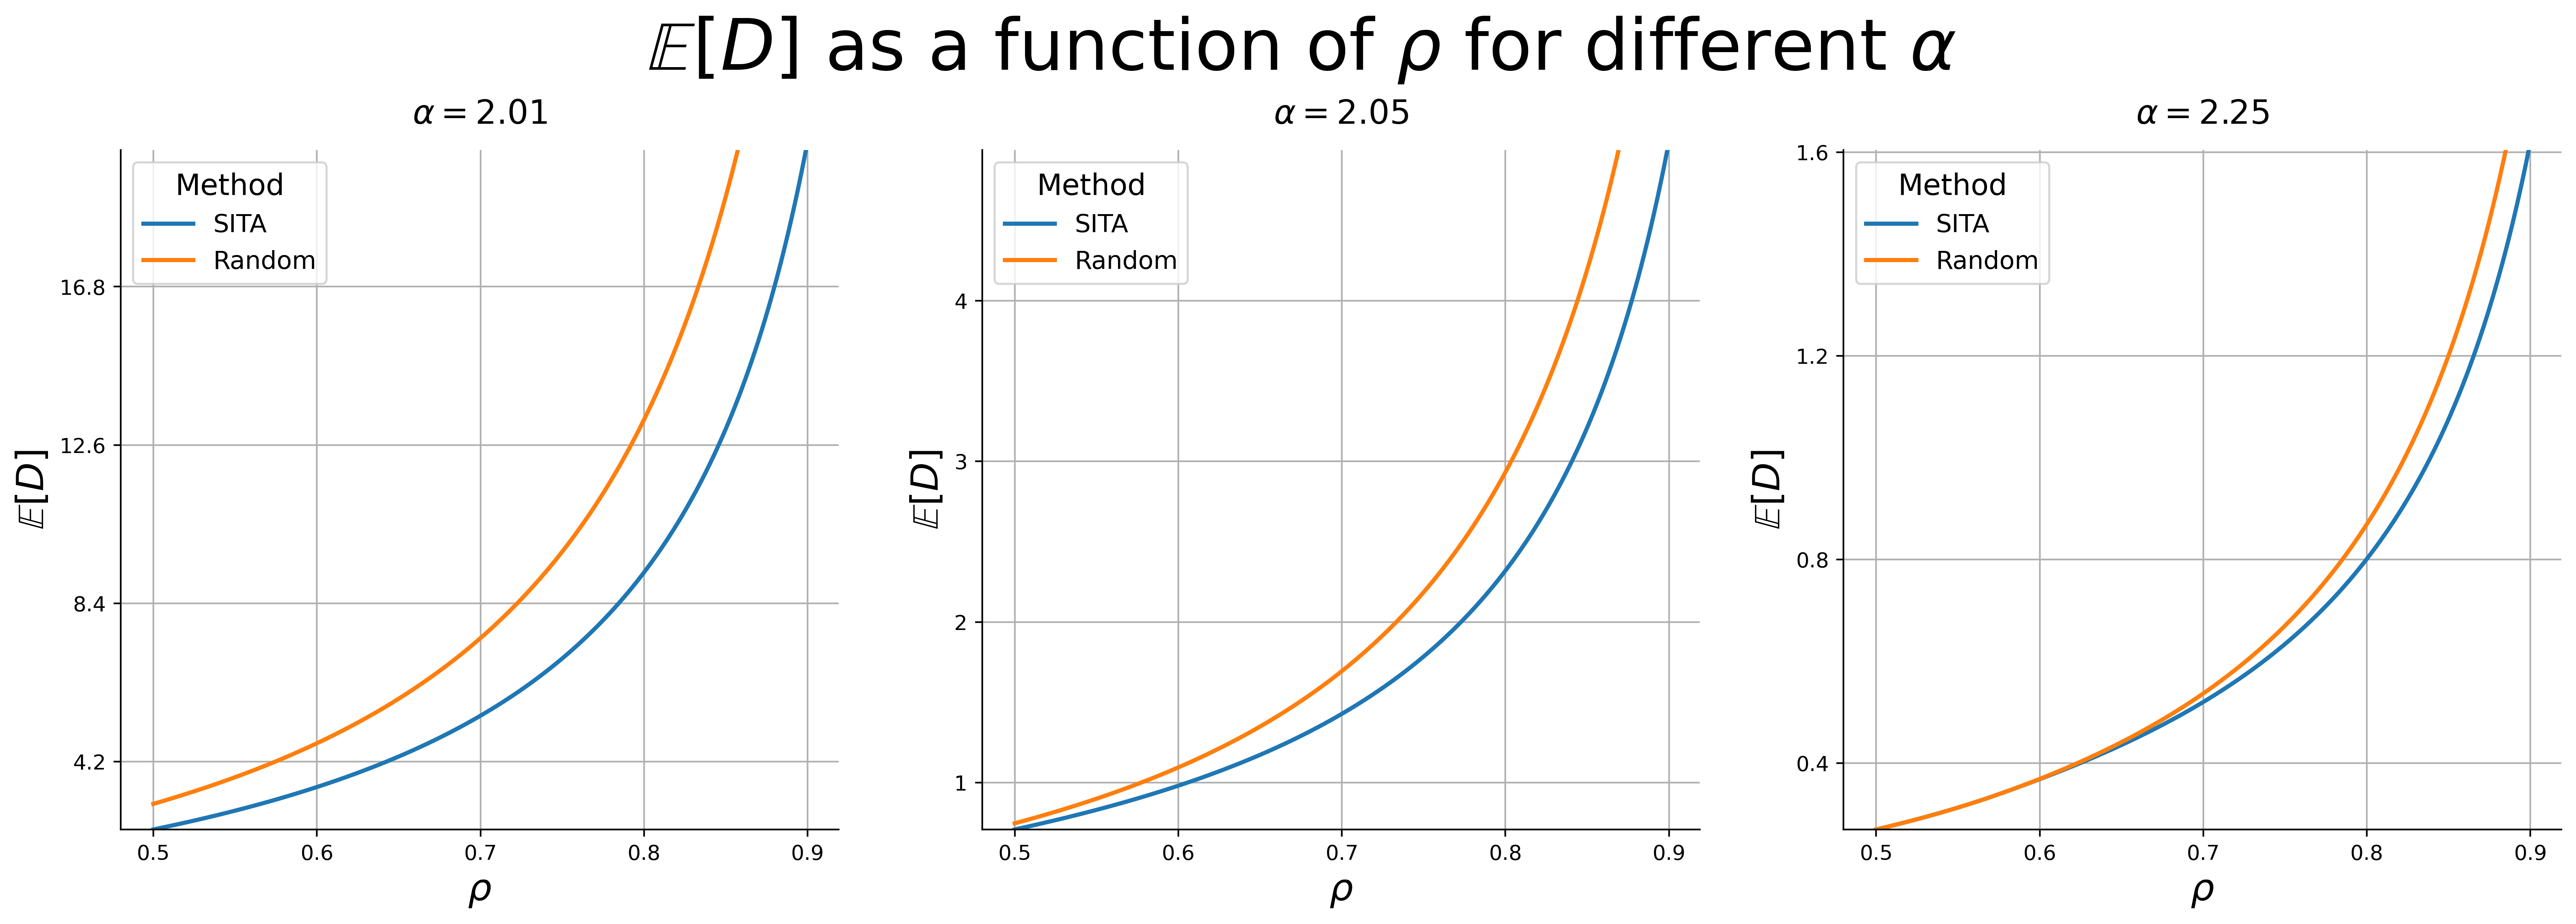

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(21,6), dpi=400)

custom_lines = [Line2D([0], [0], lw=2),
                Line2D([0], [0], color='tab:orange', lw=2)]

fig.suptitle(r'$\mathbb{E}[D]$ as a function of $\rho$ for different $\alpha$', fontsize=34, y=1.03)
for i in range(len(alphas)):
    vapeplot.despine(axs[i])
    axs[i].grid(True)
    axs[i].plot(df[(df.alpha == alphas[i]) & (df.method == 'SITA')].rho, 
                df[(df.alpha == alphas[i]) & (df.method == 'SITA')].mean_delay,
                linewidth=2)
    axs[i].plot(df[(df.alpha == alphas[i]) & (df.method == 'rand')].rho, 
                df[(df.alpha == alphas[i]) & (df.method == 'rand')].mean_delay, 
                'tab:orange',
                linewidth=2)
    axs[i].set_title(r'$\alpha = $' + str(alphas[i]), fontsize=16, y=1.02)
    axs[i].set_ylabel(r'$\mathbb{E}[D]$', fontsize=18)
    axs[i].set_xlabel(r'$\rho$', fontsize=18)
    axs[i].legend(custom_lines, ['SITA', 'Random'], title='Method', fontsize=12, title_fontsize=14)
    axs[i].set_xticks(np.arange(0.5, 0.91, 0.1))
    axs[i].set_yticks(np.arange(0, 
                                int(df[(df.alpha == alphas[i]) & (df.method == 'SITA')].mean_delay.max()) + 1, 
                                (int(df[(df.alpha == alphas[i]) & (df.method == 'SITA')].mean_delay.max() + 1))/5))
    axs[i].set_ylim(df[(df.alpha == alphas[i]) & (df.method == 'SITA')].mean_delay.min(), 
                   df[(df.alpha == alphas[i]) & (df.method == 'SITA')].mean_delay.max())